# Project in Python 2 by Luca Reichelt, 12115167
The main objective is to try and estimate a decline/rise in monthly retail US gasoline prices by parameters such as domestic production, gasoline supply, gasoline stocks, crude imports/exports, industry performances(stock prices/volumes), the SP500, as well as a consumer price index and several ratios based on these datasets.

For this objective I created a DecisionTreeClassifier and Perceptron and applied hyperparametertuning.

## Data Sources
All data refers to national averages. The CPI accounts for urban areas only.

[Production, Exports, Imports, Gas Prices, Stocks Crude, Stocks Gas, Gasoline Supplied: https://www.eia.gov/](https://www.eia.gov/petroleum/)

[CPI: https://fred.stlouisfed.org/](https://fred.stlouisfed.org/series/CPIAUCSL)

[Chevron, Exxon: https://www.macrotrends.net/](https://www.macrotrends.net/)

[SP500: https://finance.yahoo.com/](https://finance.yahoo.com/)


In [285]:
# importing the main packages
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import os
import datetime


## Raw Data
Importing the raw data and conducting first clean-ups to make dfs comparable

In [286]:
from os import listdir
from os.path import isfile, join
# Brief overview of data, which is separated into eia data and everything else by directory 
filenames_eia = [f for f in listdir("raw_data/eia_data") if isfile(join("raw_data/eia_data", f))]
print(filenames_eia)
filenames = [f for f in listdir("raw_data") if isfile(join("raw_data", f))]
print(filenames)

['U.S._Field_Production_of_Crude_Oil_Monthly.csv', 'U.S._Ending_Stocks_of_Total_Gasoline_Monthly.csv', 'U.S._Exports_of_Crude_Oil_Monthly.csv', 'U.S._Ending_Stocks_of_Crude_Oil_Monthly.csv', 'Regular_Gasoline_Retail_Prices_Monthly.csv', 'U.S._Imports_of_Crude_Oil_Monthly.csv', 'U.S._Product_Supplied_of_Finished_Motor_Gasoline_Monthly.csv']
['XOM.csv', 'CPIAUCSL.csv', 'CVX.csv', 'SP500.csv', 'MacroTrends_Data_Download_CVX.csv', 'MacroTrends_Data_Download_XOM.csv']


In [287]:
gas_prices = pd.read_csv('raw_data/eia_data/' + 'Regular_Gasoline_Retail_Prices_Monthly.csv', skiprows=4)
gas_prices["Date"]= pd.to_datetime(gas_prices["Month"])
gas_prices.set_index('Date', inplace=True)
gas_prices.drop(columns=["Month"], inplace=True)
gas_prices.sort_index(inplace=True)
first = gas_prices.index.min()
before_first = first - datetime.timedelta(days=31) 
last = gas_prices.index[-21]
# offsetting prices by one month to make comparison logic/concatenating easier
# we want to know if the price for the next month is higher/lower based
# on info from this month
gas_prices.index = gas_prices.index +pd.DateOffset(months=1)
gas_prices = gas_prices.iloc[gas_prices.index.get_loc(gas_prices.index.min()):gas_prices.index.get_loc(last)+1]


In [288]:
production = pd.read_csv('raw_data/eia_data/' + 'U.S._Field_Production_of_Crude_Oil_Monthly.csv', skiprows=4)
production["Date"]= pd.to_datetime(production["Month"])
production.set_index('Date', inplace=True)
production["Crude Production"] = production["Series ID: PET.MCRFPUS1.M Thousand Barrels"]
production.drop(columns=["Month","Series ID: PET.MCRFPUS1.M Thousand Barrels"], inplace=True)

In [289]:
stocks_gas = pd.read_csv('raw_data/eia_data/' + 'U.S._Ending_Stocks_of_Total_Gasoline_Monthly.csv', skiprows=4)
stocks_gas["Date"]= pd.to_datetime(stocks_gas["Month"])
stocks_gas.set_index('Date', inplace=True)
stocks_gas["Stocks Gas"] = stocks_gas["Series ID: PET.MGTSTUS1.M Thousand Barrels"]
stocks_gas.drop(columns=["Month","Series ID: PET.MGTSTUS1.M Thousand Barrels"], inplace=True)

In [290]:
gasoline_supplied = pd.read_csv('raw_data/eia_data/' + 'U.S._Product_Supplied_of_Finished_Motor_Gasoline_Monthly.csv', skiprows=4)
gasoline_supplied["Date"]= pd.to_datetime(gasoline_supplied["Month"])
gasoline_supplied.set_index('Date', inplace=True)
gasoline_supplied["Gasoline Supplied"] = gasoline_supplied["Series ID: PET.MGFUPUS1.M Thousand Barrels"]
gasoline_supplied.drop(columns=["Month","Series ID: PET.MGFUPUS1.M Thousand Barrels"], inplace=True)


In [291]:
stocks_crude = pd.read_csv('raw_data/eia_data/' + 'U.S._Ending_Stocks_of_Crude_Oil_Monthly.csv', skiprows=4)
stocks_crude["Date"]= pd.to_datetime(stocks_crude["Month"])
stocks_crude.set_index('Date', inplace=True)
stocks_crude["Stocks Crude"] = stocks_crude["Series ID: PET.MCRSTUS1.M Thousand Barrels"]
stocks_crude.drop(columns=["Month","Series ID: PET.MCRSTUS1.M Thousand Barrels"], inplace=True)


In [292]:
exports = pd.read_csv('raw_data/eia_data/' + 'U.S._Exports_of_Crude_Oil_Monthly.csv', skiprows=4)
exports["Date"]= pd.to_datetime(exports["Month"])
exports.set_index('Date', inplace=True)
exports["Exports"] = exports["Series ID: PET.MCREXUS1.M Thousand Barrels"]
exports.drop(columns=["Month","Series ID: PET.MCREXUS1.M Thousand Barrels"], inplace=True)


In [293]:
imports = pd.read_csv('raw_data/eia_data/' + 'U.S._Imports_of_Crude_Oil_Monthly.csv', skiprows=4)
imports["Date"]= pd.to_datetime(imports["Month"])
imports.set_index('Date', inplace=True)
imports["Imports"] = imports["Series ID: PET.MCRIMUS1.M Thousand Barrels"]
imports.drop(columns=["Month","Series ID: PET.MCRIMUS1.M Thousand Barrels"], inplace=True)

In [294]:
cpi = pd.read_csv('raw_data/CPIAUCSL.csv')
cpi["Date"]= pd.to_datetime(cpi["DATE"])
cpi.set_index('Date', inplace=True)
cpi.drop(columns=["DATE"], inplace=True)


In [295]:
exxon = pd.read_csv('raw_data/MacroTrends_Data_Download_XOM.csv', skiprows=14)
exxon["Date"]= pd.to_datetime(exxon["date"])
exxon.set_index('Date', inplace=True)
# to avoid data loss due to the first being a non-trading day, we use monthly averages
close = exxon["close"].groupby(pd.Grouper(freq='M')).mean()
volume = exxon["volume"].groupby(pd.Grouper(freq='M')).mean()
exxon = pd.concat([close, volume], axis=1).reset_index()
exxon.set_index('Date', inplace=True)
exxon.index = [pd.datetime(x.year, x.month, 1) for x in exxon.index.tolist()]
exxon.rename(columns={"close": "Exxon", "volume": "Exxon Volume"}, inplace=True)


/tmp/ipykernel_7094/3883403308.py:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [296]:
chevron = pd.read_csv('raw_data/MacroTrends_Data_Download_CVX.csv', skiprows=14)
chevron["Date"]= pd.to_datetime(chevron["date"])
chevron.set_index('Date', inplace=True)
# to avoid data loss due to the first being a non-trading day, we use monthly averages
close = chevron["close"].groupby(pd.Grouper(freq='M')).mean()
volume = chevron["volume"].groupby(pd.Grouper(freq='M')).mean()
chevron = pd.concat([close, volume], axis=1).reset_index()
chevron.set_index('Date', inplace=True)
chevron.index = [pd.datetime(x.year, x.month, 1) for x in chevron.index.tolist()]
chevron.rename(columns={"close": "Chevron", "volume": "Chevron Volume"}, inplace=True)

/tmp/ipykernel_7094/46727539.py:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [297]:
sp500 = pd.read_csv('raw_data/SP500.csv')
sp500["Date"]= pd.to_datetime(sp500["Date"])
sp500.set_index('Date', inplace=True)
# to avoid data loss due to the first being a non-trading day, we use monthly averages 
sp500["SP500"] = sp500["Value"]
sp500.drop(sp500.columns.difference(['SP500']), 1, inplace=True)

/tmp/ipykernel_7094/529128971.py:6: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



## Data clean-up

In [298]:
def cut(df):
    first = before_first
    df.sort_index(inplace=True)
    if first not in df.index:
        first = df.index.min()
    df = df.iloc[df.index.get_loc(first):df.index.get_loc(last)+1]
    return df

In [299]:
chevron = cut(chevron)
cpi = cut(cpi)
production = cut(production)
exports = cut(exports)
exxon = cut(exxon)
gas_prices = cut(gas_prices)
imports = cut(imports)
sp500 = cut(sp500)
stocks_crude = cut(stocks_crude)
stocks_gas = cut(stocks_gas)
gasoline_supplied = cut(gasoline_supplied)


In [300]:
df_list = [cpi, gas_prices, production, gasoline_supplied, stocks_gas, exports, imports, sp500, chevron, exxon]
df = pd.concat(df_list, axis=1)
df = df.iloc[df.index.is_month_start]
df.dropna(inplace=True)
df

,CPIAUCSL,Real Values,Nominal Values,Crude Production,Gasoline Supplied,Stocks Gas,Exports,Imports,SP500,Chevron,Chevron Volume,Exxon,Exxon Volume
1976-02-01,55.900,3.15,0.61,238705.0,181641.0,248901.0,0.0,122030.0,100.60,2.077605,9.581053e+05,0.836537,3.190737e+06
1976-03-01,56.000,3.12,0.60,255198.0,213605.0,239097.0,45.0,146879.0,101.10,2.079065,1.009878e+06,0.842430,2.809739e+06
1976-04-01,56.100,3.08,0.59,242310.0,214782.0,224008.0,0.0,143687.0,101.90,2.297600,1.082324e+06,0.876167,3.239314e+06
1976-05-01,56.400,3.06,0.59,251860.0,212442.0,225079.0,1.0,144748.0,101.20,2.419110,8.908000e+05,0.923040,3.759840e+06
1976-06-01,56.700,3.09,0.60,242833.0,224458.0,225408.0,0.0,168833.0,101.80,2.468064,7.161455e+05,0.966559,2.940509e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,280.126,3.54,3.39,359709.0,277432.0,232237.0,107023.0,199068.0,4674.77,114.196205,1.004029e+07,59.990477,1.965705e+07
2022-01-01,281.933,3.43,3.31,352449.0,247450.0,251753.0,103760.0,197873.0,4573.82,125.147300,1.502323e+07,69.839955,3.034585e+07
2022-02-01,284.182,3.41,3.31,316851.0,240744.0,250431.0,92654.0,172325.0,4435.98,134.289995,1.486751e+07,77.811553,3.306380e+07
2022-03-01,287.708,3.59,3.52,362329.0,274538.0,238472.0,102883.0,198883.0,4391.27,161.821826,2.292033e+07,81.507139,3.707830e+07


In [301]:
# adding several ratios that might be a good indicator
df["Crude Production to Real Price"]=df["Crude Production"]/df["Real Values"]
df["Crude Production to Exports"]=df["Crude Production"]/df["Exports"]
df["Crude Production to Imports"]=df["Crude Production"]/df["Imports"]
df["Crude Production to Stocks"]=df["Crude Production"]/df["Stocks Gas"]

df["Gasoline Supplied to Crude Production"]=df["Gasoline Supplied"]/df["Crude Production"]
df["Gasoline Supplied to Crude Exports"]=df["Gasoline Supplied"]/df["Exports"]
df["Gasoline Supplied to Crude Imports"]=df["Gasoline Supplied"]/df["Imports"]
df["Gasoline Supplied to Stocks Gas"]=df["Gasoline Supplied"]/df["Stocks Gas"]

df["Real Price to Exxon"]=df["Real Values"]/df["Exxon"]
df["Real Price to Chevron"]=df["Real Values"]/df["Chevron"]
df["Real Price to SP 500"]=df["Real Values"]/df["SP500"]
df["Real Price to CPI"]=df["Real Values"]/df["CPIAUCSL"]

# our dependent variable y: 1 if rise, 0 if decline
df["Movement"] = np.where((df["Real Values"]-df["Real Values"].shift())>0, 1, 0)

# replacing and dropping infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df

,CPIAUCSL,Real Values,Nominal Values,Crude Production,Gasoline Supplied,Stocks Gas,Exports,Imports,SP500,Chevron,...,Crude Production to Stocks,Gasoline Supplied to Crude Production,Gasoline Supplied to Crude Exports,Gasoline Supplied to Crude Imports,Gasoline Supplied to Stocks Gas,Real Price to Exxon,Real to Chevron,Real Price to SP 500,Real Price to CPI,Movement
1976-03-01,56.000,3.12,0.60,255198.0,213605.0,239097.0,45.0,146879.0,101.10,2.079065,...,1.067341,0.837017,4746.777778,1.454292,0.893382,3.703570,1.500674,0.030861,0.055714,0
1976-05-01,56.400,3.06,0.59,251860.0,212442.0,225079.0,1.0,144748.0,101.20,2.419110,...,1.118985,0.843492,212442.000000,1.467668,0.943855,3.315133,1.264928,0.030237,0.054255,0
1976-08-01,57.300,3.17,0.62,251429.0,222214.0,230614.0,380.0,172221.0,103.30,2.495514,...,1.090259,0.883804,584.773684,1.290284,0.963575,3.203977,1.270280,0.030687,0.055323,1
1976-10-01,57.900,3.17,0.63,249962.0,214799.0,226355.0,563.0,176357.0,101.90,2.398748,...,1.104292,0.859327,381.525755,1.217978,0.948947,3.170136,1.321523,0.031109,0.054750,0
1976-11-01,58.100,3.15,0.63,242388.0,211147.0,227787.0,900.0,178367.0,101.20,2.328635,...,1.064099,0.871112,234.607778,1.183778,0.926949,3.339695,1.352724,0.031126,0.054217,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,280.126,3.54,3.39,359709.0,277432.0,232237.0,107023.0,199068.0,4674.77,114.196205,...,1.548888,0.771268,2.592265,1.393654,1.194607,0.059009,0.030999,0.000757,0.012637,1
2022-01-01,281.933,3.43,3.31,352449.0,247450.0,251753.0,103760.0,197873.0,4573.82,125.147300,...,1.399979,0.702087,2.384830,1.250550,0.982908,0.049112,0.027408,0.000750,0.012166,0
2022-02-01,284.182,3.41,3.31,316851.0,240744.0,250431.0,92654.0,172325.0,4435.98,134.289995,...,1.265223,0.759802,2.598312,1.397035,0.961319,0.043824,0.025393,0.000769,0.011999,0
2022-03-01,287.708,3.59,3.52,362329.0,274538.0,238472.0,102883.0,198883.0,4391.27,161.821826,...,1.519378,0.757704,2.668449,1.380400,1.151238,0.044045,0.022185,0.000818,0.012478,1


## Visulalizing the raw data
Using plotly to make some nice interactive charts


In [302]:
import plotly.express as px

df_change = df.pct_change()



In [322]:
fig = px.area(df_change["Exxon","Exxon Volume","Real Values","SP500"], facet_col_wrap=2)
fig.show()

KeyError: ('Exxon', 'Exxon Volume', 'Real Values', 'SP500')

## Machine Learning

In [304]:

from sklearn.ensemble import RandomForestClassifier

In [305]:
y = df["Movement"]
X = df.drop(columns=("Movement"))

### Random Forest

In [323]:
params = {
    'max_depth': [2, 3, 4, 5, 11],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini"]
}


Fitting 4 folds for each of 25 candidates, totalling 100 fits
Decision tree train/test accuracies 0.703/0.548
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       228
           1       0.46      0.59      0.52       157

    accuracy                           0.55       385
   macro avg       0.55      0.55      0.55       385
weighted avg       0.57      0.55      0.55       385



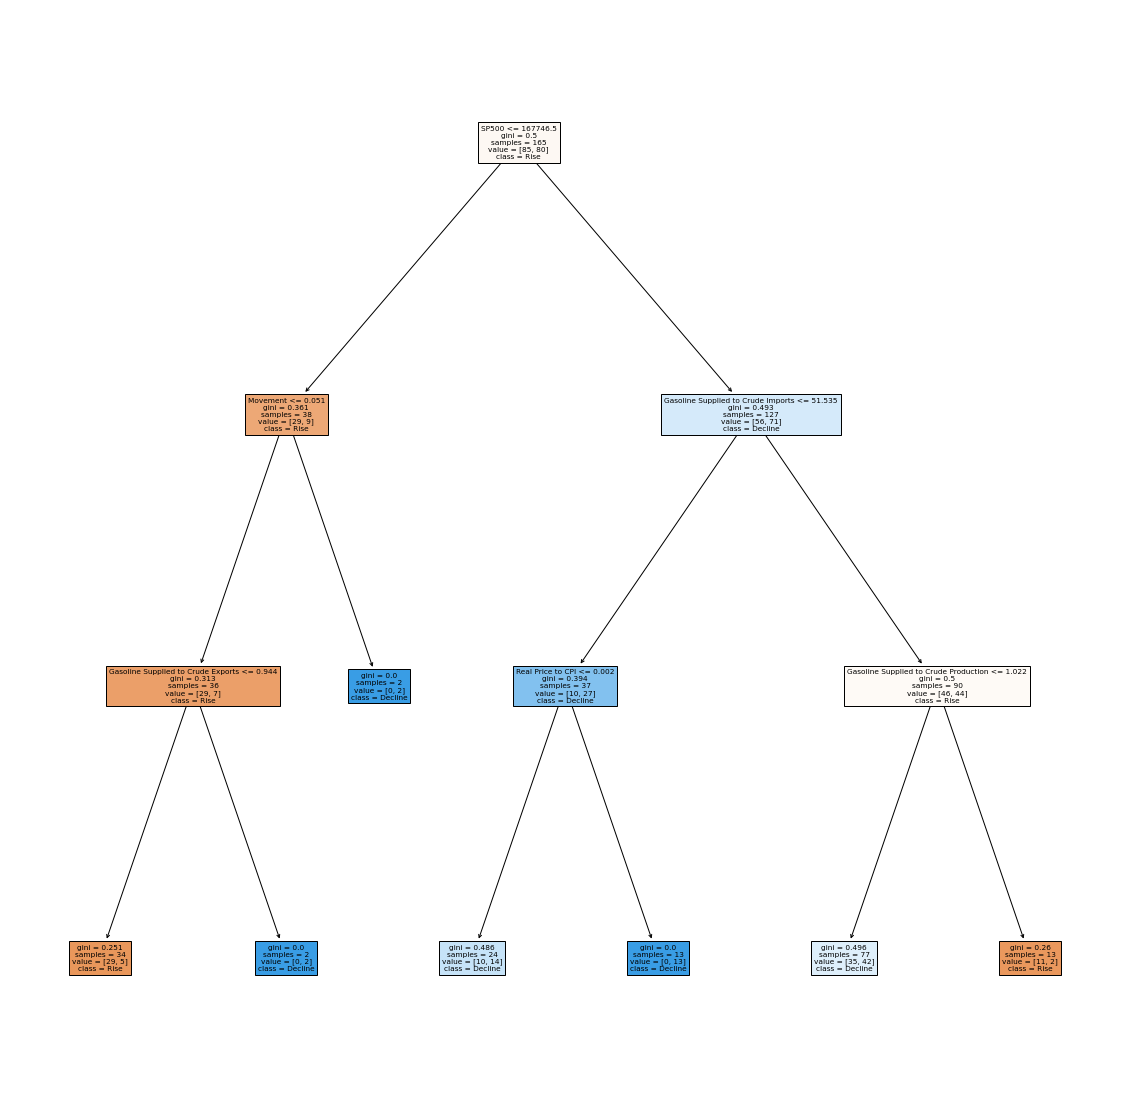

In [333]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop(columns=("Movement"))
y = df.Movement
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth=3, random_state=1)

clf.fit(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=3)

grid_search = GridSearchCV(estimator=dt,
                               param_grid=params,
                               cv=4, n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

best = grid_search.best_estimator_

fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(clf, filled=True, feature_names=df.columns[1:], class_names=["Rise", "Decline"], ax=ax)
print('Decision tree train/test accuracies %.3f/%.3f'% (accuracy_score(y_train, best.predict(X_train)), accuracy_score(y_test, best.predict(X_test))))
print(classification_report(y_test, best.predict(X_test)))
plt.show()

### Perceptron


## Results
The results indicate a slight